# Overview
- 画像で遊ぶ

In [1]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

285dc1a


# Const

In [2]:
NB = '011'
DIR_TRAIN = './../data_ignore/input/train/'
DIR_TEST = './../data_ignore/input/test/'
DIR_WIFI = './../data_ignore/input/wifi/'
PATH_SUB = './../data_ignore/input/sample_submission.csv'
PATH_99_SUB = './../data/input/floor_99per_acc_sub.csv'
DIR_SAVE_IGNORE = f'./../data_ignore/nb/{NB}/'
DIR_SAVE = f'./../data/nb/{NB}/'

# Import everything I need:)

In [3]:
import os
import time
import yaml
import json
import types
import random
import pickle
import builtins
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from tqdm import tqdm
from fastprogress import progress_bar, master_bar
from glob import glob
from loguru import logger
from collections import OrderedDict
from lmfit import Parameters, Minimizer, report_fit


# Function

In [4]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [6]:
def trace_plot(site, floor):
    # trace
    path_trace_list = sorted(glob(f'./../data_ignore/input/train/{site}/{floor}/*'))

    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    title = f'site: {site}\nfloor: {floor}'
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))

    for i_trace in range(len(path_trace_list)):
        data = read_data_file(path_trace_list[i_trace])
        waypoints = data.waypoint
        x_arr = waypoints[:, 1]
        y_arr = waypoints[:, 2]

        ax.plot(x_arr, y_arr, linewidth=2, alpha=0.5)
    return fig

In [7]:
def get_site_floor_fig(site, floor):
    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    s = max(width_meter, height_meter)
    w = round(10*width_meter/s)
    h = round(10*height_meter/s)

    # show image
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(w, h))
    fig.patch.set_facecolor('white')
    title = f'site: {site}\nfloor: {floor}'
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    return fig, ax


def gaussian2D(x, y, height, cen_x, cen_y, sig):
    return height*np.exp(-(((cen_x-x)/sig)**2 + ((cen_y-y)/sig)**2)/2.0)


def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma = p["sig"].value
    return (z - gaussian2D(x,y,height,cen_x, cen_y, sigma))

# Preparation

<br>

set

In [8]:
pd.set_option('display.max_rows', 500)

if not os.path.exists(DIR_SAVE_IGNORE):
    os.makedirs(DIR_SAVE_IGNORE)
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)

<br>

load dataset

In [9]:
sample_submission = pd.read_csv(PATH_SUB)

# EDA

In [129]:
site_idx = 13
floor_idx = 1

# site
site_list = [val.split('_')[0] for val in sample_submission.site_path_timestamp]
site_list = sorted(np.unique(site_list).tolist())

# floor
floor_list = sorted(glob(f'./../data_ignore/input/train/{site_list[site_idx]}/*'))
floor_list = [text.split('/')[-1] for text in floor_list]

site = site_list[site_idx]
floor = floor_list[floor_idx]
print(f'site : {site}')
print(f'floor: {floor}')

site : 5da1382d4db8ce0c98bbe92e
floor: F1


In [130]:
path_waypoint = f'./../data_ignore/nb/010/nb010_waypoint_{site}.csv'
df_wp = pd.read_csv(path_waypoint)
df_wp = df_wp.query('floor == @floor')

path_wifi = f'./../data_ignore/nb/004/nb004_wifi_{site}.csv'
df_wifi = pd.read_csv(path_wifi)
df_wifi = df_wifi.query('floor == @floor')

<br>

ssid でgroupbyした場合

In [131]:
n_row = 10
df_wifi_grp = df_wifi[['ssid ', 'bssid']].groupby('ssid ').nunique().sort_values('bssid', ascending=False)
display(df_wifi_grp.head(n_row).style.bar(subset=['bssid'], align='left', color=['red', 'green']))

,bssid
ssid,
da39a3ee5e6b4b0d3255bfef95601890afd80709,623
5ec944cb0e043327906acce8d1b61f6e32d8db1c,202
0b72e3ecd8f9071d311fd78bc78b4696fbbd35e5,202
0fa36db77af713808449ff54868815dc26f88e45,199
9125270d899e17b69c2944d93245c907c9104259,25
5fd2031dfdf8eac53d0756c946084f2f72b56397,15
ca969a043e538dab9b1e3d3bf0e82b34c962e019,14
cdf1b28dd0e0afc63466b9178e9063cb8abcb107,13
0cff41c510ea6e918556739b12b4de50439ebd7f,12


In [132]:
idx_ssid = 0
ssid = df_wifi_grp.index[idx_ssid]
df_wifi_ssid = df_wifi[df_wifi['ssid '] == ssid]
df_wifi_ssid_grp = df_wifi_ssid[['bssid', 'sys_ts']].groupby('bssid').count().sort_values('sys_ts', ascending=False)
print(ssid)
print(f'n_bssid: {len(df_wifi_ssid_grp)}')
df_wifi_ssid_grp.head()

da39a3ee5e6b4b0d3255bfef95601890afd80709
n_bssid: 623


,sys_ts
bssid,
ffad915cc7215f3296b354b221448f86127ef4dd,2218
86ea9335f472d309ab52dbe0e663324bd0c8fc12,2210
c2eb2940738dc6b5c0f51c408a523f4f490e3979,2080
28fae89a6dd11e17b160ad3a55734ec65f6f90a1,2040
de3c4dc15682673d584903b1bcfb0635caf97998,2028


In [133]:
idx_bssid = 1
bssid = df_wifi_ssid_grp.index[idx_bssid]
bssid

'86ea9335f472d309ab52dbe0e663324bd0c8fc12'

In [134]:
df_wifi_ssid_bssid = df_wifi_ssid.query('bssid == @bssid')
print(len(df_wifi_ssid_bssid))
df_wifi_ssid_bssid.head()

2210


,sys_ts,ssid,bssid,rssi,lastseen_ts,floor,route
542311,1571030854965,da39a3ee5e6b4b0d3255bfef95601890afd80709,86ea9335f472d309ab52dbe0e663324bd0c8fc12,-88.0,1571030831747,F1,5da40dfd27159f0006167b66
542465,1571030856921,da39a3ee5e6b4b0d3255bfef95601890afd80709,86ea9335f472d309ab52dbe0e663324bd0c8fc12,-89.0,1571030856636,F1,5da40dfd27159f0006167b66
542618,1571030858904,da39a3ee5e6b4b0d3255bfef95601890afd80709,86ea9335f472d309ab52dbe0e663324bd0c8fc12,-89.0,1571030856636,F1,5da40dfd27159f0006167b66
542767,1571030860853,da39a3ee5e6b4b0d3255bfef95601890afd80709,86ea9335f472d309ab52dbe0e663324bd0c8fc12,-89.0,1571030856636,F1,5da40dfd27159f0006167b66
542929,1571030862889,da39a3ee5e6b4b0d3255bfef95601890afd80709,86ea9335f472d309ab52dbe0e663324bd0c8fc12,-89.0,1571030856636,F1,5da40dfd27159f0006167b66


---> あるssidに属するあるbssidを取得した！

ssid : da39a3ee5e6b4b0d3255bfef95601890afd80709
bssid: 86ea9335f472d309ab52dbe0e663324bd0c8fc12


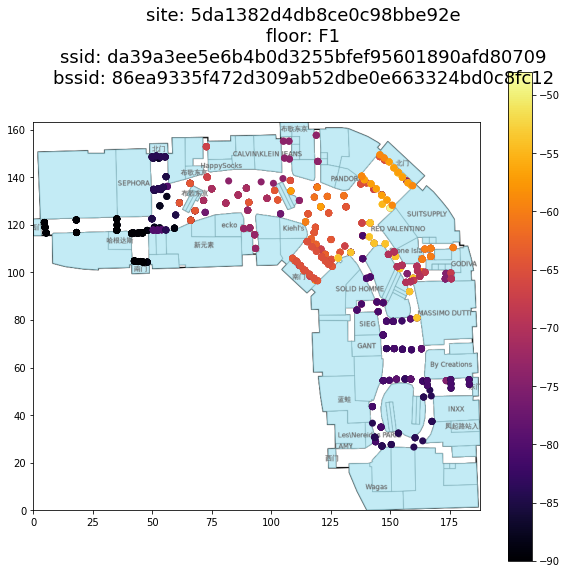

In [135]:
ts_wp = df_wp['timestamp'].values
sec = 5

# あるwifiのlast_seen_timestamp の前後 sec 秒以内 のwaypointを取得する
fig, ax = get_site_floor_fig(site, floor)
x_arr = []
y_arr = []
rssi_arr = []
for idx, row in df_wifi_ssid_bssid.iterrows():
    lastseen_ts = row.lastseen_ts
    rssi = row['rssi']
    logics = (lastseen_ts/1000.0 - sec <= ts_wp/1000.0) & (ts_wp/1000.0 < lastseen_ts/1000.0 + sec)
    if np.sum(logics) != 0:
        _x_arr = df_wp[logics].x
        _y_arr = df_wp[logics].y
        _rssi_arr = [rssi]*len(_x_arr)
        x_arr = x_arr + _x_arr.tolist()
        y_arr = y_arr + _y_arr.tolist()
        rssi_arr = rssi_arr + _rssi_arr
scatter = ax.scatter(x_arr, y_arr, c=rssi_arr, linewidths=0, s=50, cmap='inferno')
fig.colorbar(scatter, ax=ax)
print(f'ssid : {ssid}')
print(f'bssid: {bssid}')
title = f'site: {site}\nfloor: {floor}\nssid: {ssid}\nbssid: {bssid}'
_ = fig.suptitle(title, fontsize=18)

--- 

In [136]:
path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
with open(path_json) as json_file:
    json_data = json.load(json_file)
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

(226, 3)

(226, 3)

ssid : da39a3ee5e6b4b0d3255bfef95601890afd80709
bssid: 86ea9335f472d309ab52dbe0e663324bd0c8fc12


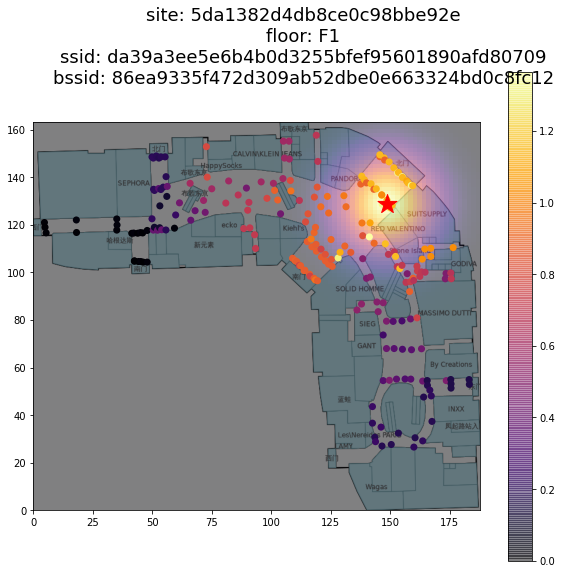

In [160]:
n_grid = 100
sec = 5
ts_wp = df_wp['timestamp'].values

# あるwifiのlast_seen_timestamp の前後 sec 秒以内 のwaypointを取得する
fig, ax = get_site_floor_fig(site, floor)
x_arr = []
y_arr = []
rssi_arr = []
for idx, row in df_wifi_ssid_bssid.iterrows():
    lastseen_ts = row.lastseen_ts
    rssi = row['rssi']
    logics = (lastseen_ts/1000.0 - sec <= ts_wp/1000.0) & (ts_wp/1000.0 < lastseen_ts/1000.0 + sec)
    if np.sum(logics) != 0:
        _x_arr = df_wp[logics].x
        _y_arr = df_wp[logics].y
        _rssi_arr = [rssi]*len(_x_arr)
        x_arr = x_arr + _x_arr.tolist()
        y_arr = y_arr + _y_arr.tolist()
        rssi_arr = rssi_arr + _rssi_arr

df = pd.DataFrame({'x': x_arr, 'y': y_arr, 'rssi': rssi_arr})
df = df.groupby(['x', 'y']).mean().reset_index()
x_arr = df.x.values
y_arr = df.y.values
rssi_arr = df.rssi.values

# ----
gauss = np.zeros([n_grid, n_grid])
x, y = np.meshgrid(np.linspace(0, width_meter, n_grid), np.linspace(0, height_meter, n_grid))
c = np.exp(np.max(rssi_arr))
for i in range(len(x_arr)):
    gauss += gaussian2D(x, y, 1/c*np.exp(rssi_arr[i]), x_arr[i], y_arr[i], 10)
    
initial = Parameters()
initial.add("height", value=1)
initial.add("centroid_x", value=width_meter/2)
initial.add("centroid_y", value=height_meter/2)
initial.add("sig", value=100)

fit = Minimizer(residuals, initial, fcn_args=(x, y, gauss))
out = fit.leastsq()
best_params = [param.value for _, param in out.params.items()]
best_fit = gaussian2D(x, y, best_params[0], best_params[1], best_params[2], best_params[3])
# ----

# g = ax.imshow(gauss, cmap="inferno", extent=(0, width_meter, 0, height_meter), alpha=0.5, origin="lower",)
g = ax.imshow(best_fit, cmap="inferno", extent=(0, width_meter, 0, height_meter), alpha=0.5, origin="lower")
scatter = ax.scatter(x_arr, y_arr, c=rssi_arr, linewidths=0, s=50, cmap='inferno')
ax.scatter(best_params[1], best_params[2], s=400, marker='*', color='red')

fig.colorbar(g, ax=ax)
print(f'ssid : {ssid}')
print(f'bssid: {bssid}')
title = f'site: {site}\nfloor: {floor}\nssid: {ssid}\nbssid: {bssid}'
_ = fig.suptitle(title, fontsize=18)